# Perceiver + MRL Vision-Text Alignment

This notebook implements **Perceiver-based vision-text alignment with Matryoshka Representation Learning (MRL)** for Qwen decoder compatibility.

## Key Features:

1. **Perceiver Resampler** for vision:
   - Compresses patch tokens from CLIP to fixed-size latents
   - `num_latents=64`, `latent_dim=1024`, `num_layers=4`, `num_heads=8`

2. **MRL with Qwen-compatible dimensions**:
   - Top dimension: **4096** (Qwen hidden size)
   - MRL dimensions: `[4096, 3072, 2048, 1536, 1024, 768, 512]`
   - Sample single MRL dimension per batch for efficiency

3. **Loss Configuration**:
   - `mrl_weight = 1.0` (primary loss)
   - `clip_weight = 0.25` (auxiliary loss)

4. **Training Best Practices**:
   - AdamW optimizer with `lr=2e-4`, `betas=(0.9, 0.95)`
   - Warmup (5%) + Cosine decay scheduler
   - Gradient clipping at `max_norm=1.0`
   - Frozen encoders, trainable Perceiver + projectors

5. **Evaluation**:
   - Image-to-text and text-to-image retrieval (R@1, R@5, R@10)
   - Similarity analysis (positive vs negative pairs)
   - Per-dimension MRL performance tracking

6. **Checkpoint for Next Stage**:
   - Saves model with Perceiver config
   - Compatible with TRM/Qwen decoder initialization
   - Includes `encode_image()` and `encode_text()` APIs

**Hardware Requirements:**
- 1-2 H200 GPUs
- ~40-50GB GPU memory per GPU

## 1. Setup and Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
from pathlib import Path

# Add src to path
sys.path.insert(0, str(Path.cwd().parent / "src"))
Path.cwd().parent / "src"

PosixPath('/storage/ice1/1/0/vchopra37/projects/edge_glass/edge_glass_modular/src')

In [3]:
# Import standard libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from tqdm.auto import tqdm
import wandb
from datetime import datetime
from dataclasses import dataclass, asdict
import json
import os

# Import our modular components
from config import load_config
from encoders.perceiver import PerceiverResampler
from models.losses import AlignmentLoss, contrastive_loss
from data.dataset_builder import build_image_datasets_from_parquet
from data.transforms import get_image_transforms
from training.improved_trainer import ImprovedMultimodalTrainer
from utils.visualization import TrainingVisualizer

/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/transformers/utils/hub.py:110: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [4]:
# Set up matplotlib
%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')

# Set random seeds
torch.manual_seed(42)
np.random.seed(42)

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


PyTorch version: 2.9.0+cu128
CUDA available: True
GPU: NVIDIA H200
GPU Memory: 150.11 GB
Using device: cuda:1


## 2. Configuration with MRL Dimensions for Qwen

In [5]:
# Load experiment configuration
config_path = "../configs/perceiver_mrl_alignment.yaml"
config = load_config(config_path)

# Print configuration
print("="*60)
print("EXPERIMENT CONFIGURATION")
print("="*60)
print(f"\nExperiment: {config.name}")
print(f"\nDataset:")
print(f"  Train: {config.dataset.train_parquet}")
print(f"  Val: {config.dataset.val_parquet}")
print(f"  Image size: {config.dataset.image_size}")
print(f"  Text dropout: {config.dataset.text_dropout_prob}")

print(f"\nPerceiver Configuration:")
print(f"  Num latents: {config.vision_encoder.perceiver_num_latents}")
print(f"  Latent dim: {config.vision_encoder.perceiver_latent_dim}")
print(f"  Num layers: {config.vision_encoder.perceiver_num_layers}")
print(f"  Num heads: {config.vision_encoder.perceiver_num_heads}")

print(f"\nMRL Configuration:")
print(f"  Projection dim (top): {config.vision_encoder.projection_dim}")
print(f"  MRL dimensions: {config.vision_encoder.mrl_dimensions}")
print(f"  Sample single dim: {config.losses.sample_single_mrl_dim}")

print(f"\nLoss Configuration:")
print(f"  MRL weight: {config.losses.mrl}")
print(f"  CLIP weight: {config.losses.contrastive}")

print(f"\nTraining Configuration:")
print(f"  Batch size: {config.dataset.batch_size}")
print(f"  Learning rate: {config.optimization.lr}")
print(f"  Weight decay: {config.optimization.weight_decay}")
print(f"  Betas: {config.optimization.betas}")
print(f"  Max grad norm: {config.optimization.max_grad_norm}")
print(f"  Warmup ratio: {config.optimization.warmup_ratio}")
print(f"  LR scheduler: {config.optimization.lr_scheduler}")
print(f"  Epochs: {config.trainer.epochs}")
print("="*60)

EXPERIMENT CONFIGURATION

Experiment: perceiver_mrl_alignment

Dataset:
  Train: /home/hice1/vchopra37/scratch/projects/edge_glass/dataset/final_dataset/pixmo/pixmo_train.parquet
  Val: /home/hice1/vchopra37/scratch/projects/edge_glass/dataset/final_dataset/pixmo/pixmo_val.parquet
  Image size: 336
  Text dropout: 0.1

Perceiver Configuration:
  Num latents: 64
  Latent dim: 1024
  Num layers: 4
  Num heads: 8

MRL Configuration:
  Projection dim (top): 4096
  MRL dimensions: [3072, 2048, 1536, 1024, 768, 512]
  Sample single dim: True

Loss Configuration:
  MRL weight: 1.0
  CLIP weight: 0.25

Training Configuration:
  Batch size: 64
  Learning rate: 0.0002
  Weight decay: 0.01
  Betas: [0.9, 0.95]
  Max grad norm: 1.0
  Warmup ratio: 0.05
  LR scheduler: cosine
  Epochs: 10


## 3. Perceiver-Based Alignment Model

This model uses:
- **CLIP vision encoder** (frozen) → patch tokens `(B, T_img, d_enc)`
- **Linear adapter** `d_enc → latent_dim` before Perceiver
- **Perceiver Resampler** → `(B, K=64, latent_dim=1024)` vision tokens
- **MLP projector** `latent_dim → 4096` for vision
- **CLIP text encoder** (frozen) → pooled `(B, d_txt)`
- **MLP projector** `d_txt → 4096` for text
- **L2 normalization** on both outputs before loss computation

In [6]:
from models.alignment import MultimodalAlignmentModel

# Create model
print(f"\nUsing device: {device}")

model = MultimodalAlignmentModel(config).to(device)

print(f"\nModel Architecture:")
print(f"  Total parameters: {model.num_total_parameters:,}")
print(f"  Trainable parameters: {model.num_trainable_parameters:,}")
print(f"  Trainable %: {100 * model.num_trainable_parameters / model.num_total_parameters:.2f}%")

# Print component breakdown
print(f"\nComponent Breakdown:")
model.print_parameter_counts()


Using device: cuda:1

Model Architecture:
  Total parameters: 485,405,952
  Trainable parameters: 58,838,016
  Trainable %: 12.12%

Component Breakdown:
Component                            Trainable           Total
------------------------------------------------------------
Vision Encoder                      55,688,192     359,195,648
Text Encoder                         3,149,824     126,210,304
------------------------------------------------------------
TOTAL                               58,838,016     485,405,952


## 4. MRL Loss Functions

Implements:
- **CLIP loss** on full 4096-dim embeddings
- **MRL loss** with dimension sampling from `mrl_dims`
- Combined loss: `mrl_weight * loss_mrl + clip_weight * loss_clip`

In [7]:
# Loss functions are imported from models.losses
# The AlignmentLoss class handles combined CLIP + MRL losses
# Configuration for loss weights is already set in the config file

print("Using AlignmentLoss with:")
print(f"  CLIP weight: {config.losses.contrastive}")
print(f"  MRL weight: {config.losses.mrl}")
print(f"  Sample single MRL dim: {config.losses.sample_single_mrl_dim}")

Using AlignmentLoss with:
  CLIP weight: 0.25
  MRL weight: 1.0
  Sample single MRL dim: True


## 5. Load PixMo Dataset from Parquet

In [8]:
# Get transforms
train_transforms = get_image_transforms(image_size=config.dataset.image_size, is_training=True)
val_transforms = get_image_transforms(image_size=config.dataset.image_size, is_training=False)

# Build datasets from parquet
print("Loading PixMo datasets from parquet files...")

datasets = build_image_datasets_from_parquet(
    cfg=config,
    train_parquet_path=config.dataset.train_parquet,
    val_parquet_path=config.dataset.val_parquet,
    test_parquet_path=config.dataset.test_parquet,
    train_transforms=train_transforms,
    val_transforms=val_transforms,
    max_text_length=config.dataset.max_text_length,
    text_dropout_prob=config.dataset.text_dropout_prob,
)

train_dataset = datasets['train']
val_dataset = datasets['val']
test_dataset = datasets.get('test', None)

print(f"\nDataset sizes:")
print(f"  Train: {len(train_dataset):,}")
print(f"  Val: {len(val_dataset):,}")
if test_dataset:
    print(f"  Test: {len(test_dataset):,}")

# Create dataloaders
num_gpus = torch.cuda.device_count() if torch.cuda.is_available() else 1
batch_size = config.dataset.batch_size * num_gpus

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=config.dataset.num_workers,
    pin_memory=config.dataset.pin_memory,
    persistent_workers=config.dataset.persistent_workers if config.dataset.num_workers > 0 else False,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=config.trainer.eval_batch_size,
    shuffle=False,
    num_workers=config.dataset.num_workers,
    pin_memory=config.dataset.pin_memory,
)

print(f"\nDataLoader configuration:")
print(f"  Batch size (total): {batch_size} ({config.dataset.batch_size} x {num_gpus} GPUs)")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches: {len(val_loader)}")
print(f"  Num workers: {config.dataset.num_workers}")

Loading PixMo datasets from parquet files...


/storage/ice1/1/0/vchopra37/projects/edge_glass/edge_glass_modular/src/data/dataset_builder.py:153: UserWarning: Removed 88 invalid images from /home/hice1/vchopra37/scratch/projects/edge_glass/dataset/final_dataset/pixmo/pixmo_train.parquet. Downstream loaders will skip them.
  warnings.warn(
/storage/ice1/1/0/vchopra37/projects/edge_glass/edge_glass_modular/src/data/dataset_builder.py:153: UserWarning: Removed 16 invalid images from /home/hice1/vchopra37/scratch/projects/edge_glass/dataset/final_dataset/pixmo/pixmo_val.parquet. Downstream loaders will skip them.
  warnings.warn(



Dataset sizes:
  Train: 13,912
  Val: 2,984
  Test: 2,980

DataLoader configuration:
  Batch size (total): 128 (64 x 2 GPUs)
  Train batches: 109
  Val batches: 24
  Num workers: 8


/storage/ice1/1/0/vchopra37/projects/edge_glass/edge_glass_modular/src/data/dataset_builder.py:153: UserWarning: Removed 20 invalid images from /home/hice1/vchopra37/scratch/projects/edge_glass/dataset/final_dataset/pixmo/pixmo_test.parquet. Downstream loaders will skip them.
  warnings.warn(


## 6. Visualize Sample Data

/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Batch keys: dict_keys(['image', 'text', 'sample_id'])
Image shape: torch.Size([128, 3, 336, 336])
Number of captions: 128


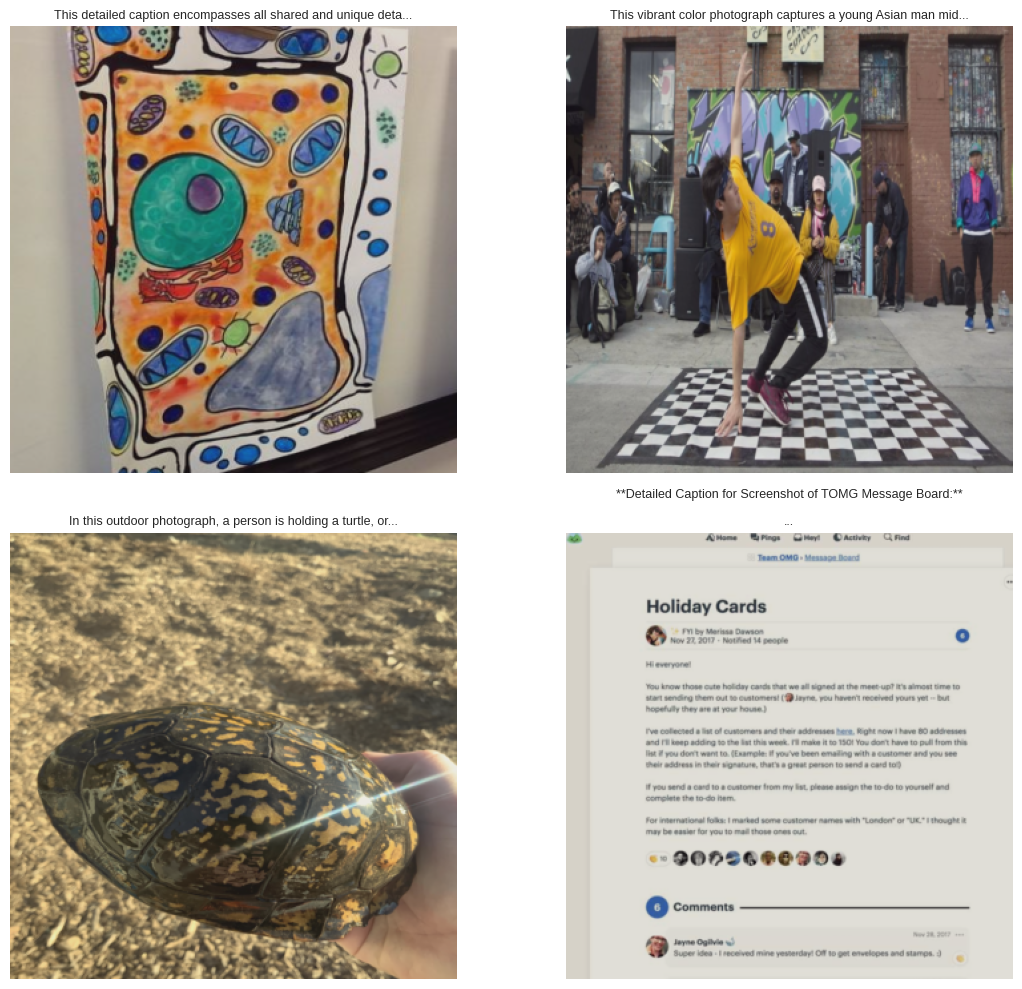


Note: Some captions show '[DROPPED]' due to text dropout.


/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [ ]:
# Get a sample batch
sample_batch = next(iter(train_loader))
print(f"Batch keys: {sample_batch.keys()}")
print(f"Image shape: {sample_batch['image'].shape}")
print(f"Number of captions: {len(sample_batch['text'])}")

# Visualize
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for idx in range(min(4, len(sample_batch['image']))):
    img = sample_batch['image'][idx].cpu()
    # Denormalize
    img = img * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    img = img + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    img = torch.clamp(img, 0, 1)
    img = img.permute(1, 2, 0).numpy()
    
    axes[idx].imshow(img)
    caption = sample_batch['text'][idx] if sample_batch['text'][idx] else "[DROPPED]"
    axes[idx].set_title(caption[:60] + "...", fontsize=9)
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

print("\nNote: Some captions show '[DROPPED]' due to text dropout.")

## 7. Training Setup: Optimizer and Scheduler

Following Molmo/TRM best practices:
- AdamW with `betas=(0.9, 0.95)`
- Warmup for 5% of steps
- Cosine decay to 0.1x initial LR

In [10]:
# Delete the old inline optimizer cell - we'll use ImprovedMultimodalTrainer instead
# The trainer handles optimizer, scheduler, gradient scaling, and all training logic

## 8. Evaluation Functions

In [11]:
# Delete the old inline evaluation functions - ImprovedMultimodalTrainer handles this
# The trainer includes built-in retrieval metrics and evaluation

## 9. Training Loop

In [12]:
# Initialize trainer with improved features
use_wandb = config.trainer.use_wandb

trainer = ImprovedMultimodalTrainer(
    cfg=config,
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    use_wandb=use_wandb,
)

print("\nTrainer initialized with:")
print(f"  Checkpoint directory: {trainer.ckpt_dir}")
print(f"  Effective batch size: {trainer.effective_batch_size}")
print(f"  World size (GPUs): {trainer.world_size}")
print(f"  Starting epoch: {trainer.state.epoch}")
print(f"  Starting step: {trainer.state.global_step}")
print(f"  Best val loss: {trainer.state.best_val_loss}")

print("\n" + "="*60)
print("STARTING TRAINING")
print("="*60)

# Train
history = trainer.train()

print("\n" + "="*60)
print("TRAINING COMPLETED")
print("="*60)
print(f"Best validation loss: {trainer.state.best_val_loss:.4f}")
print("="*60)

[2025-12-03 20:15:24][WARNING] DDP requested but no distributed process group found. Falling back to single-process training. Launch with torchrun to enable DDP.
109 10 1
[2025-12-03 20:15:24][INFO] No checkpoint found. Starting training from scratch.


/storage/ice1/1/0/vchopra37/projects/edge_glass/edge_glass_modular/src/training/improved_trainer.py:109: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(enabled=cfg.optimization.fp16 or cfg.optimization.bf16)
wandb: Currently logged in as: vedaangchopra (vedaangchopra_gatech) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin



Trainer initialized with:
  Checkpoint directory: checkpoints/perceiver_mrl_alignment
  Effective batch size: 64
  World size (GPUs): 1
  Starting epoch: 0
  Starting step: 0
  Best val loss: inf

STARTING TRAINING
[2025-12-03 20:15:26][INFO] Starting training...
[2025-12-03 20:15:26][INFO] Epochs: 10
[2025-12-03 20:15:26][INFO] Steps per epoch: 109
[2025-12-03 20:15:26][INFO] Total training steps: 1090
[2025-12-03 20:15:26][INFO] Effective batch size: 64
[2025-12-03 20:15:26][INFO] 
Epoch 1/10


/storage/ice1/1/0/vchopra37/projects/edge_glass/edge_glass_modular/src/training/improved_trainer.py:286: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.cfg.optimization.fp16 or self.cfg.optimization.bf16):


OutOfMemoryError: CUDA out of memory. Tried to allocate 144.00 MiB. GPU 0 has a total capacity of 139.80 GiB of which 77.88 MiB is free. Process 577895 has 124.68 GiB memory in use. Including non-PyTorch memory, this process has 15.01 GiB memory in use. Of the allocated memory 14.31 GiB is allocated by PyTorch, and 29.72 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

## 10. Visualize Training Results

In [ ]:
# Initialize visualizer
from pathlib import Path
output_dir = Path(config.trainer.output_dir)
output_dir.mkdir(parents=True, exist_ok=True)
visualizer = TrainingVisualizer(save_dir=output_dir)

# Plot training curves
visualizer.plot_training_curves(history)
print(f"Training curves saved to {output_dir / 'training_curves.png'}")

# Plot loss components
visualizer.plot_loss_components(history)
print(f"Loss components saved to {output_dir / 'loss_components.png'}")

# Plot LR schedule
if 'lr' in history and history['lr']:
    visualizer.plot_lr_schedule(history['lr'])
    print(f"LR schedule saved to {output_dir / 'lr_schedule.png'}")

# Display training curves
from IPython.display import Image as IPImage, display
display(IPImage(filename=str(output_dir / 'training_curves.png')))

## 11. Load Best Model and Test

In [ ]:
# Load best checkpoint
best_ckpt_path = Path(config.trainer.ckpt_dir) / "checkpoint_best.pt"
if best_ckpt_path.exists():
    checkpoint = torch.load(best_ckpt_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"Loaded best model from {best_ckpt_path}")
    print(f"  Epoch: {checkpoint['epoch']}")
    print(f"  Best val loss: {checkpoint['best_val_loss']:.4f}")
else:
    print("No best checkpoint found, using current model state.")

model.eval()

## 12. Test Retrieval Examples

In [ ]:
# Collect small test set for retrieval visualization
test_images = []
test_texts = []
test_vision_embs = []
test_text_embs = []

with torch.no_grad():
    for batch_idx, batch in enumerate(val_loader):
        if batch_idx >= 5:  # First 5 batches
            break
        
        images = batch['image'].to(device)
        texts = batch['text']
        
        # Skip dropped texts
        valid_indices = [i for i, t in enumerate(texts) if t]
        if not valid_indices:
            continue
        
        images = images[valid_indices]
        texts = [texts[i] for i in valid_indices]
        
        # Forward pass with return_embeddings=True
        outputs = model(images=images, texts=texts, return_embeddings=True)
        
        test_images.extend([images[i].cpu() for i in range(len(images))])
        test_texts.extend(texts)
        test_vision_embs.append(outputs.vision_emb.cpu())
        test_text_embs.append(outputs.text_emb.cpu())

test_vision_embs = torch.cat(test_vision_embs, dim=0)
test_text_embs = torch.cat(test_text_embs, dim=0)

print(f"Collected {len(test_texts)} test samples")

# Test retrieval for a few examples
num_examples = 3
for i in range(num_examples):
    print(f"\n{'='*60}")
    print(f"Example {i+1}")
    print(f"{'='*60}")
    print(f"Ground Truth Caption: {test_texts[i]}")
    
    # Compute similarities
    query_emb = test_vision_embs[i:i+1]
    similarities = torch.matmul(query_emb, test_text_embs.t()).squeeze(0)
    
    # Get top 5
    top_indices = torch.argsort(similarities, descending=True)[:5]
    
    print("\nTop 5 Retrieved Captions:")
    for rank, idx in enumerate(top_indices, 1):
        match = "✓ MATCH" if idx == i else ""
        print(f"  {rank}. [{similarities[idx]:.3f}] {test_texts[idx][:80]}... {match}")

## 13. Evaluate MRL Performance at Different Dimensions

In [ ]:
# Evaluate retrieval at different MRL dimensions
mrl_performance = {}

for dim in cfg.mrl_dims:
    # Truncate embeddings
    vision_trunc = test_vision_embs[:, :dim]
    text_trunc = test_text_embs[:, :dim]
    
    # Normalize
    vision_trunc = F.normalize(vision_trunc, p=2, dim=-1)
    text_trunc = F.normalize(text_trunc, p=2, dim=-1)
    
    # Compute similarity
    sim_matrix = torch.matmul(vision_trunc, text_trunc.t())
    
    # I2T retrieval
    i2t_ranks = []
    for i in range(sim_matrix.shape[0]):
        sorted_indices = torch.argsort(sim_matrix[i], descending=True)
        rank = (sorted_indices == i).nonzero(as_tuple=True)[0].item()
        i2t_ranks.append(rank)
    
    i2t_ranks = np.array(i2t_ranks)
    i2t_r1 = (i2t_ranks < 1).mean() * 100
    i2t_r5 = (i2t_ranks < 5).mean() * 100
    
    mrl_performance[dim] = {
        'r1': i2t_r1,
        'r5': i2t_r5,
    }
    
    print(f"Dim {dim:4d}: R@1 = {i2t_r1:.2f}%, R@5 = {i2t_r5:.2f}%")

# Plot MRL performance
plt.figure(figsize=(10, 6))
dims = list(mrl_performance.keys())
r1_scores = [mrl_performance[d]['r1'] for d in dims]
r5_scores = [mrl_performance[d]['r5'] for d in dims]

plt.plot(dims, r1_scores, marker='o', linewidth=2, label='R@1')
plt.plot(dims, r5_scores, marker='s', linewidth=2, label='R@5')
plt.xlabel('Embedding Dimension')
plt.ylabel('Recall (%)')
plt.title('MRL Performance vs Dimension')
plt.legend()
plt.grid(True)
plt.xscale('log')

mrl_fig_path = Path(cfg.output_dir) / "mrl_performance.png"
plt.savefig(mrl_fig_path, dpi=150, bbox_inches='tight')
plt.show()

print(f"\nMRL performance plot saved to {mrl_fig_path}")

In [ ]:
# Accuracy sweep across MRL embedding sizes (image->text top-1)
dims_to_test = sorted({config.vision_encoder.projection_dim, *config.vision_encoder.mrl_dimensions})
eval_samples = getattr(config.trainer, "retrieval_eval_samples", 200)

# Collect validation embeddings
val_vision_embs = []
val_text_embs = []
collected = 0
eval_device = next(model.parameters()).device

with torch.no_grad():
    for batch in val_loader:
        images = batch["image"].to(eval_device)
        texts = batch["text"]

        valid_indices = [i for i, t in enumerate(texts) if t]
        if not valid_indices:
            continue

        images = images[valid_indices]
        texts = [texts[i] for i in valid_indices]

        outputs = model(images=images, texts=texts, return_embeddings=True)
        val_vision_embs.append(outputs.vision_emb.cpu())
        val_text_embs.append(outputs.text_emb.cpu())

        collected += len(texts)
        if collected >= eval_samples:
            break

val_vision_embs = torch.cat(val_vision_embs, dim=0)[:eval_samples]
val_text_embs = torch.cat(val_text_embs, dim=0)[:eval_samples]
num_eval = val_vision_embs.shape[0]
print(f"Collected {num_eval} validation pairs for MRL accuracy sweep")

accuracy_by_dim = {}

for dim in dims_to_test:
    vision_trunc = F.normalize(val_vision_embs[:, :dim], p=2, dim=-1)
    text_trunc = F.normalize(val_text_embs[:, :dim], p=2, dim=-1)
    sim = torch.matmul(vision_trunc, text_trunc.t())
    top1 = torch.argmax(sim, dim=1)
    acc = (top1 == torch.arange(num_eval)).float().mean().item() * 100
    accuracy_by_dim[dim] = acc
    print(f"Dim {dim:4d}: Top-1 accuracy = {acc:.2f}%")

dims = list(accuracy_by_dim.keys())
acc_values = [accuracy_by_dim[d] for d in dims]

plt.figure(figsize=(10, 6))
plt.plot(dims, acc_values, marker='o', linewidth=2, color='#4c72b0')
plt.xlabel('Embedding Dimension')
plt.ylabel('Top-1 Accuracy (%)')
plt.title('Image→Text Retrieval Accuracy vs MRL Dimension')
plt.xscale('log')
plt.grid(True, alpha=0.3)

acc_fig_path = Path(config.trainer.output_dir) / "mrl_dim_accuracy.png"
plt.savefig(acc_fig_path, dpi=150, bbox_inches='tight')
plt.show()

print(f"Accuracy plot saved to {acc_fig_path}")


## 14. Save Final Model for TRM/Qwen Decoder

This checkpoint can be used to initialize the next stage with TRM/Qwen decoder.

In [ ]:
# Save final checkpoint with all necessary info for next stage
final_checkpoint = {
    # Model state
    'model_state_dict': model.state_dict(),
    
    # Configuration
    'config': asdict(cfg),
    
    # Perceiver configuration for reconstruction
    'perceiver_config': {
        'num_latents': cfg.perceiver_num_latents,
        'latent_dim': cfg.perceiver_latent_dim,
        'num_layers': cfg.perceiver_num_layers,
        'num_heads': cfg.perceiver_num_heads,
        'dropout': cfg.perceiver_dropout,
    },
    
    # MRL configuration
    'mrl_dims': cfg.mrl_dims,
    'projection_dim': cfg.projection_dim,
    
    # Vision encoder info
    'vision_encoder_name': cfg.vision_encoder_name,
    'text_encoder_name': cfg.text_encoder_name,
    
    # Training info
    'best_val_loss': best_val_loss,
    'final_metrics': history,
    
    # Metadata
    'training_date': datetime.now().isoformat(),
    'num_epochs': cfg.epochs,
    'total_steps': global_step,
}

final_ckpt_path = Path(cfg.ckpt_dir) / "perceiver_mrl_alignment_final.pt"
torch.save(final_checkpoint, final_ckpt_path)

print("\n" + "="*60)
print("FINAL MODEL SAVED")
print("="*60)
print(f"Checkpoint: {final_ckpt_path}")
print(f"\nModel specifications:")
print(f"  Vision tokens: {cfg.perceiver_num_latents}")
print(f"  Token dimension: {cfg.projection_dim}")
print(f"  MRL dimensions: {cfg.mrl_dims}")
print(f"\nTo use with TRM/Qwen decoder:")
print(f"  1. Load checkpoint with torch.load('{final_ckpt_path}')")
print(f"  2. Extract vision encoder: model.vision_encoder")
print(f"  3. Use encode_image() to get (B, 64, 4096) vision tokens")
print(f"  4. Feed to Qwen decoder with hidden_size=4096")
print("="*60)

## 15. Summary and Next Steps

In [ ]:
print("\n" + "="*60)
print("EXPERIMENT SUMMARY")
print("="*60)

print(f"\nConfiguration:")
print(f"  Model: Perceiver + MRL Alignment")
print(f"  Vision Encoder: {config.vision_encoder.model_name}")
print(f"  Perceiver: {config.vision_encoder.perceiver_num_latents} latents × {config.vision_encoder.perceiver_latent_dim}d × {config.vision_encoder.perceiver_num_layers} layers")
print(f"  Projection dim: {config.vision_encoder.projection_dim}")
print(f"  MRL dimensions: {config.vision_encoder.mrl_dimensions}")

print(f"\nTraining:")
print(f"  Epochs: {config.trainer.epochs}")
print(f"  Best val loss: {trainer.state.best_val_loss:.4f}")

if 'val_i2t_r1' in history and history['val_i2t_r1']:
    best_r1 = max(history['val_i2t_r1'])
    best_r5 = max(history['val_i2t_r5'])
    best_r10 = max(history['val_i2t_r10'])
    print(f"\nBest Retrieval Performance:")
    print(f"  I2T R@1: {best_r1:.2f}%")
    print(f"  I2T R@5: {best_r5:.2f}%")
    print(f"  I2T R@10: {best_r10:.2f}%")

print(f"\nModel Parameters:")
print(f"  Total: {model.num_total_parameters:,}")
print(f"  Trainable: {model.num_trainable_parameters:,}")
print(f"  Trainable %: {100*model.num_trainable_parameters/model.num_total_parameters:.2f}%")

print(f"\nOutput Files:")
print(f"  Best checkpoint: {Path(config.trainer.ckpt_dir) / 'checkpoint_best.pt'}")
print(f"  Latest checkpoint: {Path(config.trainer.ckpt_dir) / 'checkpoint_latest.pt'}")
print(f"  Training history: {Path(config.trainer.ckpt_dir) / 'training_history.json'}")
print(f"  Visualizations: {config.trainer.output_dir}")

print("\n" + "="*60)
print("NEXT STEPS")
print("="*60)
print("1. Load the final checkpoint in the next notebook")
print("2. Initialize TRM/Qwen decoder with hidden_size=4096")
print("3. Connect vision encoder output (B, 64, 4096) to decoder")
print("4. Fine-tune on instruction-following tasks")
print("5. Evaluate on downstream VL benchmarks")
print("="*60)

print("\n✓ Notebook complete!")